In [1]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception, ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

/opt/ohpc/pub/apps/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
DATA_DIR = Path('/scratch/imb/Andrew/HEMnet')
TRAIN_DIR = DATA_DIR.joinpath('train_dataset_10x_13_12_19_strict/tiles_10x')
VAL_DIR = DATA_DIR.joinpath('gold_standards/1794_T/tiles_10x')

In [3]:
TRAIN_CANCER_DIR = TRAIN_DIR.joinpath('cancer')
TRAIN_NON_CANCER_DIR = TRAIN_DIR.joinpath('non-cancer')
VAL_CANCER_DIR = VAL_DIR.joinpath('cancer')
VAL_NON_CANCER_DIR = VAL_DIR.joinpath('non-cancer')

In [4]:
print('Training cancer images: ', len(list(TRAIN_CANCER_DIR.glob('*jpeg'))))
print('Training non-cancer images: ', len(list(TRAIN_NON_CANCER_DIR.glob('*jpeg'))))
print('Validation cancer images: ', len(list(VAL_CANCER_DIR.glob('*jpeg'))))
print('Validation non-cancer images: ', len(list(VAL_NON_CANCER_DIR.glob('*jpeg'))))

Training cancer images:  2979
Training non-cancer images:  3315
Validation cancer images:  1021
Validation non-cancer images:  724


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes = ['cancer','non-cancer'],
    target_size = (299,299),
    batch_size = 256,
    class_mode = 'binary')

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    classes = ['cancer','non-cancer'],
    target_size = (299,299),
    batch_size = 256,
    class_mode = 'binary')

Found 6294 images belonging to 2 classes.
Found 1745 images belonging to 2 classes.


In [7]:
xception_base = Xception(weights = 'imagenet', include_top = False)
x = xception_base.output
features = layers.GlobalMaxPooling2D()(x)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
conv_base = Model(xception_base.input, features)

In [9]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [10]:
conv_base.output_shape

(None, 2048)

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [14]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [21]:
history = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch=100,
    validation_data = val_generator,
    validation_steps = 50)

Epoch 1/30
25/25 [==============================] - 51s 2s/step - loss: 0.2429 - acc: 0.9191 - val_loss: 0.4221 - val_acc: 0.8115
Epoch 2/30
25/25 [==============================] - 24s 967ms/step - loss: 0.2281 - acc: 0.9277 - val_loss: 0.4086 - val_acc: 0.8115
Epoch 3/30
25/25 [==============================] - 24s 972ms/step - loss: 0.2093 - acc: 0.9296 - val_loss: 0.3943 - val_acc: 0.8252
Epoch 4/30
25/25 [==============================] - 24s 973ms/step - loss: 0.1961 - acc: 0.9344 - val_loss: 0.3876 - val_acc: 0.8355
Epoch 5/30
25/25 [==============================] - 24s 972ms/step - loss: 0.1779 - acc: 0.9423 - val_loss: 0.4075 - val_acc: 0.8109
Epoch 6/30
25/25 [==============================] - 24s 971ms/step - loss: 0.1687 - acc: 0.9458 - val_loss: 0.3756 - val_acc: 0.8436
Epoch 7/30
25/25 [==============================] - 24s 970ms/step - loss: 0.1618 - acc: 0.9506 - val_loss: 0.3685 - val_acc: 0.8510
Epoch 8/30
25/25 [==============================] - 24s 973ms/step - los

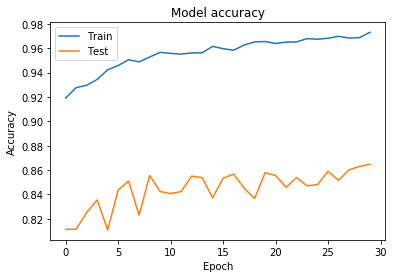

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

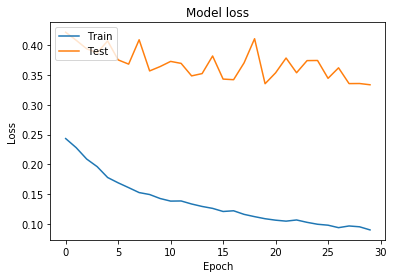

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(array([653., 158., 118.,  70.,  62.,  59.,  61.,  61.,  86., 417.]),
 array([2.29477882e-06, 1.00000408e-01, 1.99998522e-01, 2.99996635e-01,
        3.99994749e-01, 4.99992862e-01, 5.99990976e-01, 6.99989089e-01,
        7.99987203e-01, 8.99985316e-01, 9.99983430e-01]),
 <a list of 10 Patch objects>)

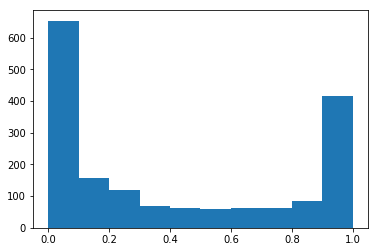

In [25]:
val_sigmoid = model.predict_generator(val_generator)
plt.hist(val_sigmoid)

In [26]:
val_generator.class_indices

{'cancer': 0, 'non-cancer': 1}

In [27]:
val_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [30]:
cm = confusion_matrix(val_generator.classes, (val_sigmoid > 0.5).astype(np.int64))
cm

array([[621, 400],
       [440, 284]])

In [32]:
def plot_confusion_matrix(cm, classes=None):
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 300)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

[[0.60822723 0.39177277]
 [0.60773481 0.39226519]]


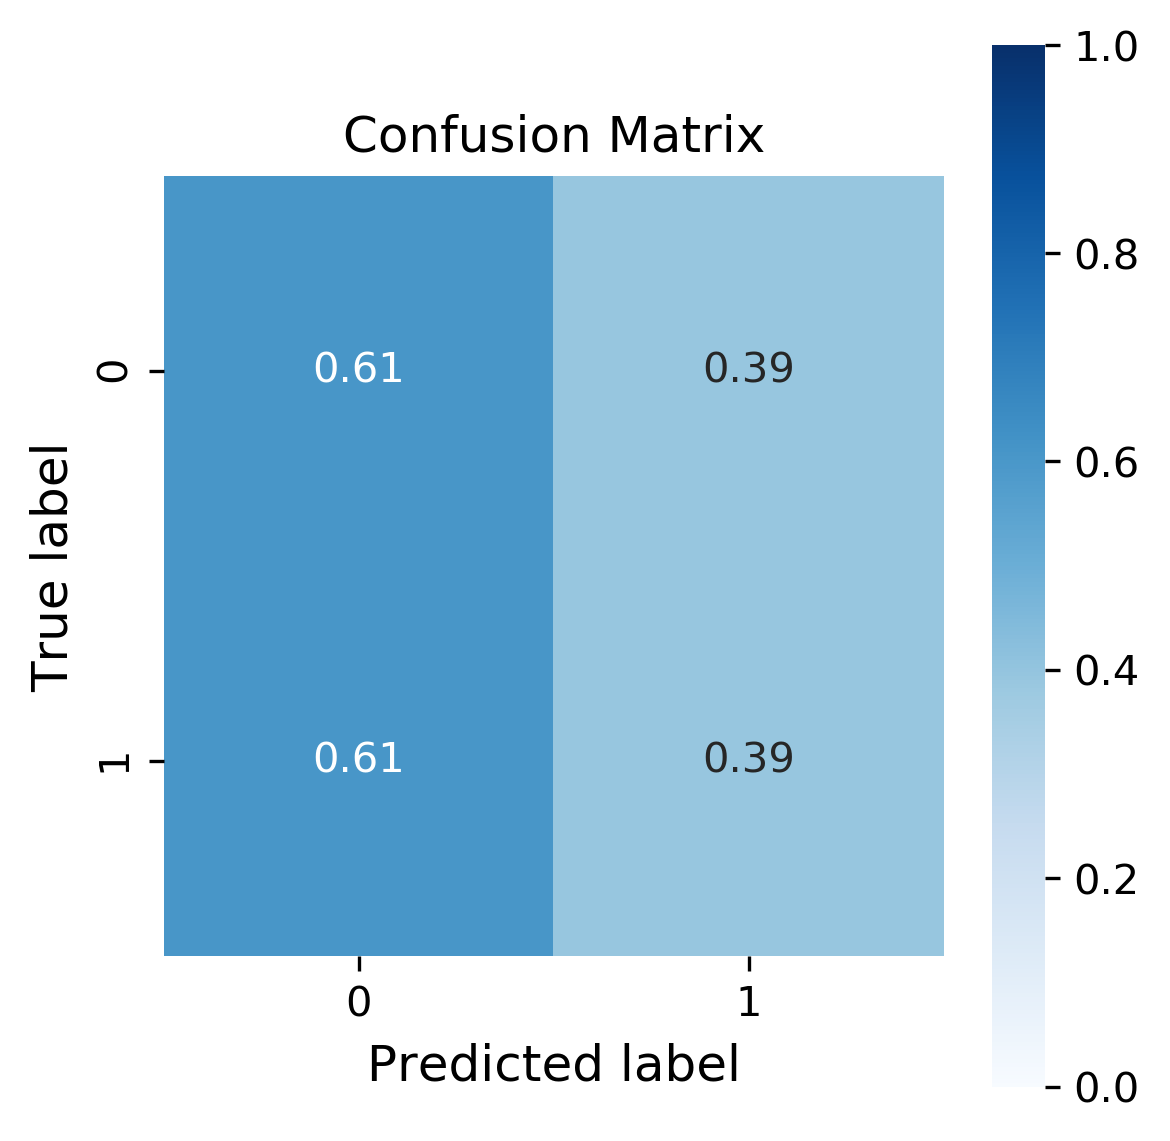

In [37]:
plot_confusion_matrix(cm)